### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

# Regresión no lineal

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [26]:
def base_polinomial(X, deg=3):
    n = X.shape[0]
    Phi = np.ones(n)
    for i in range(1, deg+1):
        Phi = np.vstack([Phi, X**i])
    return Phi.T

def base_coseno(x, deg=1, T=2):
    """
    x: array of 1d observations
    d: degree
    T:period
    """
    phi_x = np.ones((len(x), deg+1)) # container
    for d in range(1, deg + 1):
        phi_x[:, d] = np.cos(d * 2 * np.pi / deg / T * x)
    return phi_x

# Carga de datos

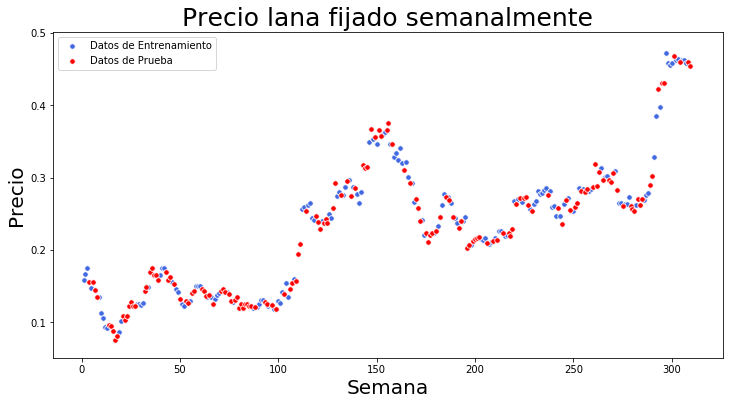

In [27]:
datos = np.loadtxt("../datos/wool.csv", delimiter=',')
x = datos[:,0]
y = datos[:,1]

plt.figure(0, figsize=(12,6))

prop = 0.5
p = int(prop * len(x))
train_points = np.sort(np.random.choice(len(x), p, replace=False))
test_points = np.array([int(i) for i in range(len(x)) if i not in train_points])

x_tr = x[train_points]; y_tr = y[train_points]
x_te = x[test_points]; y_te = y[test_points]
plt.scatter(x_tr, y_tr, c='royalblue', s=30, label='Datos de Entrenamiento', edgecolor='w', linewidths=0.8)
plt.scatter(x_te, y_te, c='red', s=30, label='Datos de Prueba', edgecolor='w', linewidths=0.8)
plt.legend()
plt.title("Precio lana fijado semanalmente", size=25)
plt.xlabel("Semana", size=20)
plt.ylabel("Precio", size=20);

# Regresión Lineal

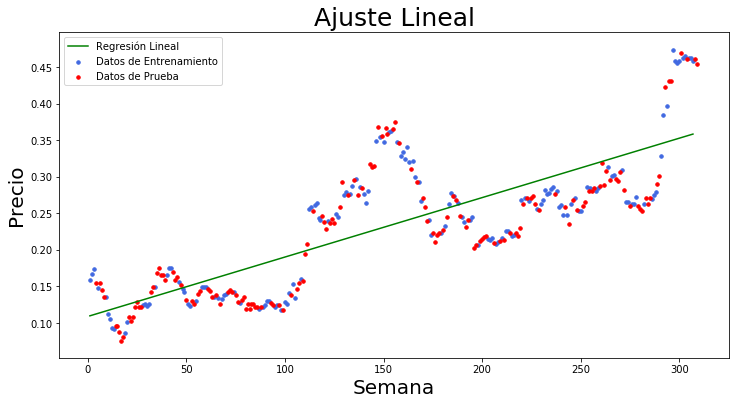

In [28]:

rho = 1
X = np.vstack([np.ones(len(x_tr)), x_tr]).T
Inv_1 = np.linalg.inv(np.matmul(X.T,X) + rho*np.eye(2))
W1 = np.dot(Inv_1, np.dot(X.T, y_tr))
y_reg1 = np.matmul(X,W1)

#Graficos
plt.figure(0, figsize=(12,6))
plt.scatter(x_tr, y_tr, c='royalblue', s=12, label='Datos de Entrenamiento')
plt.scatter(x_te, y_te, c='red', s=12, label='Datos de Prueba')
plt.plot(x_tr, y_reg1, 'green', label='Regresión Lineal')
plt.title("Ajuste Lineal", size=25)
plt.xlabel("Semana", size=20)
plt.ylabel("Precio", size=20)
plt.legend()


rms1_tr = np.mean(((y_tr-y_reg1)**2)/y_tr)
X_te = np.vstack([np.ones(len(x_te)), x_te]).T
y_reg1_te = np.matmul(X_te,W1)
rms1_te = np.mean(((y_te-y_reg1_te)**2)/y_te);

# Regresión Polinomial

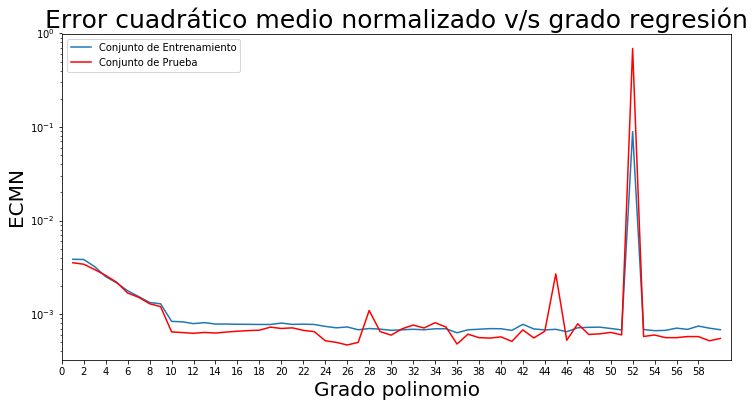

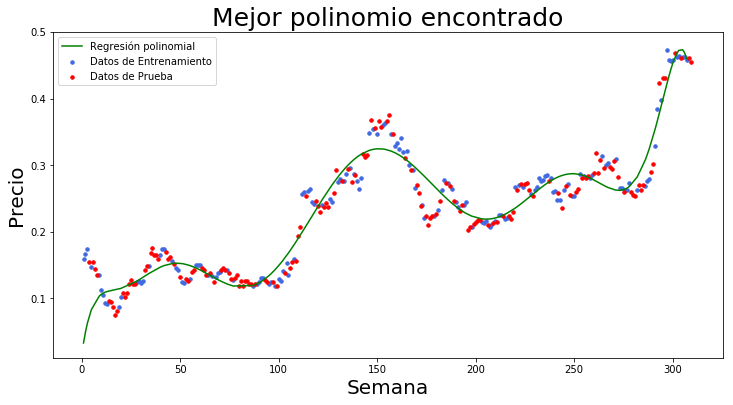

In [41]:
max_grad = 60
rho = 30
rms_tr = np.zeros(max_grad)
rms_te = np.zeros(max_grad)
for i in range(1, max_grad + 1):
    phi_i = base_polinomial(x_tr, deg=i)
    #inv_i = np.linalg.inv(np.matmul(phi_i.T, phi_i) + rho*np.eye(i+1))
    #w_i = np.dot(inv_i, np.dot(phi_i.T, y_tr))
    w_i = np.linalg.solve(np.matmul(phi_i.T, phi_i) + rho*np.eye(i+1), np.dot(phi_i.T, y_tr))
    y_reg_i = np.matmul(phi_i,w_i)
    rms_tr[i-1] = np.mean(((y_tr-y_reg_i)**2))
    phi_te = base_polinomial(x_te, deg=i)
    y_i_te = np.matmul(phi_te, w_i)
    rms_te[i-1] = np.mean(((y_te-y_i_te)**2))

plt.figure(1, figsize=(12,6))
plt.semilogy(range(1, max_grad+1), rms_tr, label='Conjunto de Entrenamiento')
plt.semilogy(range(1, max_grad+1), rms_te, 'red', label='Conjunto de Prueba')
plt.xlim(1, max_grad + 1)
plt.xticks(np.arange(0,max_grad,2))
plt.title("Error cuadrático medio normalizado v/s grado regresión", size=25)
plt.xlabel("Grado polinomio", size=20)
plt.ylabel("ECMN", size=20)
plt.legend()

N_pol = 12
Phi_pol = base_polinomial(x_tr, deg=N_pol)
#Inv_pol = np.linalg.inv(np.matmul(Phi_pol.T, Phi_pol) + rho*np.eye(N_pol+1))
#w_pol = np.dot(Inv_pol, np.dot(Phi_pol.T, y_tr))
w_pol = np.linalg.solve(np.matmul(Phi_pol.T, Phi_pol) + rho*np.eye(N_pol+1), np.dot(Phi_pol.T, y_tr))


y_reg_pol = np.matmul(Phi_pol, w_pol)

plt.figure(0, figsize=(12,6))
plt.scatter(x_tr, y_tr, c='royalblue', s=12, label='Datos de Entrenamiento')
plt.scatter(x_te, y_te, c='red', s=12, label='Datos de Prueba')
plt.plot(x_tr, y_reg_pol, 'green', label='Regresión polinomial')
plt.title("Mejor polinomio encontrado", size=25)
plt.xlabel("Semana", size=20)
plt.ylabel("Precio", size=20);
plt.legend()

# Regresión con base coseno sobre los residuos de la señal
- En esta parte se toman los datos originales y se les resta la mejor regresión polinomial obtenida.
- Luego se hace regresión sobre la señal residual usando una base sinusoidal.
- Finalmente se muestra lo obtenido al juntar la regresión polinomial más la regresión con bases coseno de forma jerarquica.

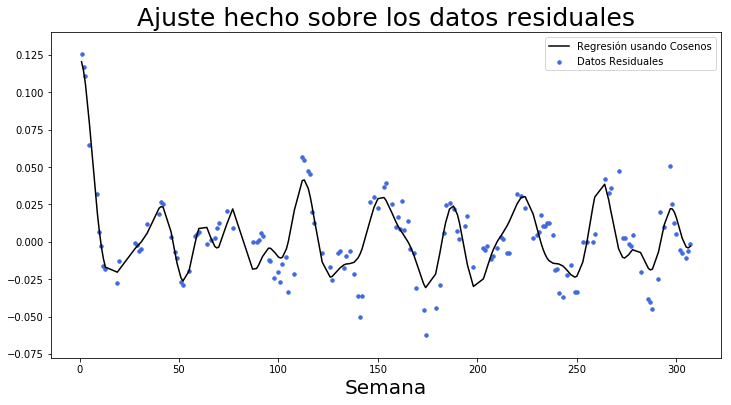

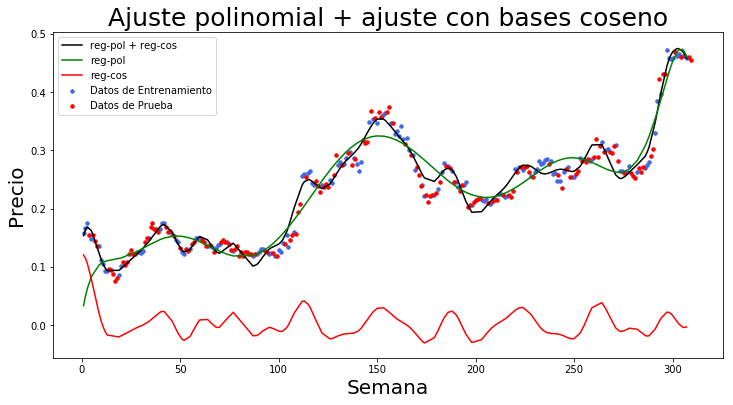

In [44]:
res_tr = y_tr-y_reg_pol

plt.figure(0,figsize=(12,6))
plt.scatter(x_tr, res_tr, c='royalblue', s=12, label='Datos Residuales')

deg = 25 #20
T = 15
rho = 1
Phi_cos = base_coseno(x_tr, deg=deg, T=T)
#Inv_cos = np.linalg.inv(np.matmul(Phi_cos.T, Phi_cos) + rho*np.eye(deg+1))
#W_cos = np.dot(Inv_cos, np.dot(Phi_cos.T, res_tr))

W_cos = np.linalg.solve(np.matmul(Phi_cos.T, Phi_cos) + rho*np.eye(deg+1),np.dot(Phi_cos.T, res_tr))
y_reg_cos = np.matmul(Phi_cos,W_cos)
plt.plot(x_tr, y_reg_cos, 'k', label='Regresión usando Cosenos')
plt.title("Ajuste hecho sobre los datos residuales", size=25)
plt.xlabel("Semana", size=20)
plt.legend()


plt.figure(1, figsize=(12,6))
plt.scatter(x_tr, y_tr, c='royalblue', s=12, label='Datos de Entrenamiento')
plt.scatter(x_te, y_te, c='red', s=12, label='Datos de Prueba')
plt.plot(x_tr, (y_reg_pol+y_reg_cos), 'k', label='reg-pol + reg-cos')
plt.plot(x_tr, y_reg_pol, 'green', label='reg-pol')
plt.plot(x_tr, y_reg_cos, 'red', label='reg-cos')
plt.title("Ajuste polinomial + ajuste con bases coseno", size=25)
plt.xlabel("Semana", size=20)
plt.ylabel("Precio", size=20)
plt.legend();

In [48]:
w_pol

array([ 1.31914750e-02,  2.18784576e-02, -1.98442102e-03,  9.35733982e-05,
       -2.45223501e-06,  3.87204175e-08, -3.92110434e-10,  2.65428518e-12,
       -1.22475242e-14,  3.83315813e-17, -7.82985940e-20,  9.44798601e-23,
       -5.11223292e-26])